In [1]:
from gurobipy import *
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# Testing

In [2]:
output_file = 'variable_values'


In [3]:
results = pd.read_table(f'../output/{output_file}.txt')
n = results[results["results"].str.contains("n")]
u = results[results["results"].str.contains("u")]
c = results[results["results"].str.contains("c")]
varn = n['results'].str.split('=').apply(lambda x: x[0])
valn = n['results'].str.split('=').apply(lambda x: x[1])
t = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
k = varn.str.split('n').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
amount = valn
specificn = pd.DataFrame(np.array([t,i,k,amount]).T).reset_index(drop=True)
specificn.columns = ['t','i', 'k', 'amount']
specificn['name'] = 'n'

varu = u['results'].str.split('=').apply(lambda x: x[0])
valu = u['results'].str.split('=').apply(lambda x: x[1])
t = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
j = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
k = varu.str.split('u').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valu
specificu = pd.DataFrame(np.array([t,i,j,k,amount]).T).reset_index(drop=True)
specificu.columns = ['t','i', 'j', 'k', 'amount']
specificu['name'] = 'u'

varc = c['results'].str.split('=').apply(lambda x: x[0])
valc = c['results'].str.split('=').apply(lambda x: x[1])
t = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[0])
i = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[1])
x = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[2])
y = varc.str.split('c').apply(lambda x: ast.literal_eval(x[1])).apply(lambda x: x[3])
amount = valc
specificc = pd.DataFrame(np.array([t,i,x,y,amount]).T).reset_index(drop=True)
specificc.columns = ['t','i', 'x', 'y', 'amount']
specificc['name'] = 'c'
specificn['amount'] = specificn['amount'].astype(float)
specificu['amount'] = specificu['amount'].astype(float)
specificc['amount'] = specificc['amount'].astype(float)


In [4]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

In [5]:
specificu01 = specificu01.groupby('t').sum().reset_index()
specificu10 = specificu10.groupby('t').sum().reset_index()


In [6]:
gamma = [3.237872699, 3.729470167, 4.404786588, 5.379957014, 6.913363091,
        9.685271742, 16.30528373, 71.41103553]
gamma = np.array(gamma) / 5
gamma = np.ceil(gamma)

In [7]:
specificc['t'].max()

1151

In [8]:
end = 1151

In [9]:
all_c = np.zeros(shape=(1,end), dtype=int)
for i in range(specificc.shape[0]):
    val = int(specificc['amount'][i])
    soc0 = int(specificc['x'][i])
    soc1 = int(specificc['y'][i])
    t = int(specificc['t'][i])
    time_charge = int(gamma[soc0: soc1].sum())
    occupied = np.zeros(shape=(val,end))
    for j in range(val):
        occupied[j][t:t+time_charge] = 1

    all_c = np.concatenate([all_c, occupied], axis=0)
all_c = all_c[1:,:]

all_u = np.zeros(shape=(1,end), dtype=int)
for i in range(specificu.shape[0]):
    val = int(specificu['amount'][i])
    t = int(specificu['t'][i])
    flight_time = 2
    flight = np.zeros(shape=(val,end))
    for j in range(val):
        flight[j][t:t+flight_time] = 1

    all_u = np.concatenate([all_u, flight], axis=0)
all_u = all_u[1:,:]

In [10]:

all_n = np.zeros(shape=(1,end+2), dtype=int)
for i in range(specificn.shape[0]):
    val = int(specificn['amount'][i])
    t = int(specificn['t'][i])
    idle = np.zeros(shape=(val,end+2))
    for j in range(val):
        idle[j][t] = 1
    all_n = np.concatenate([all_n, idle], axis=0)
all_n = all_n[1:,:-1]

## Total Number of Aircraft Checking

<Axes: >

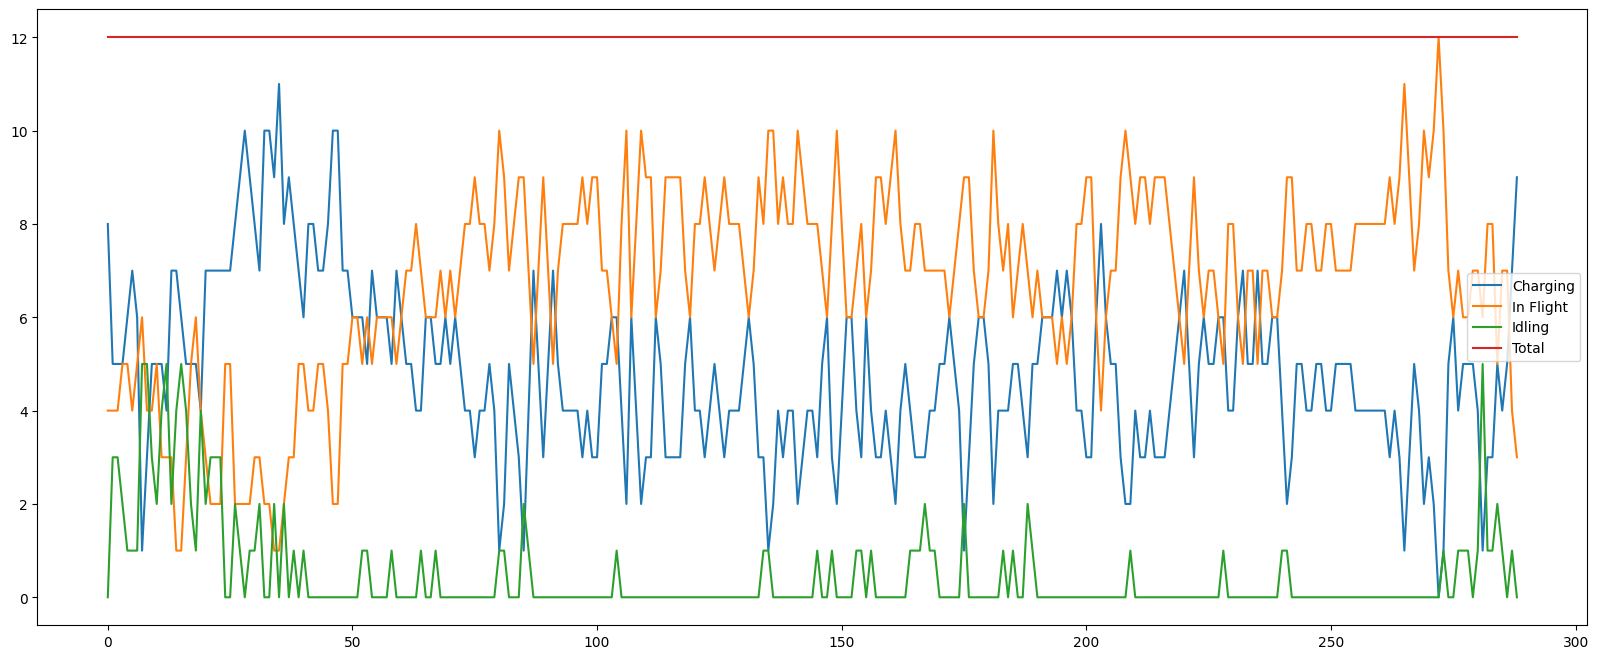

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
x0 = 144+288
x1 = 144+288*2+1

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1]+all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)

In [14]:
display(all_c.sum(axis=0)[144])
display(all_u.sum(axis=0)[144])
display(all_n.sum(axis=0)[144])

8.0

4.0

0.0

In [15]:
display(all_c.sum(axis=0)[144+288])
display(all_u.sum(axis=0)[144+288])
display(all_n.sum(axis=0)[144+288])

8.0

4.0

0.0

In [17]:
specificu01 = specificu[specificu['i'] == 0]
specificu10 = specificu[specificu['i'] == 1]

In [18]:
specificu01 = specificu01.groupby('t').sum().reset_index()
specificu10 = specificu10.groupby('t').sum().reset_index()


# N-T Diagram

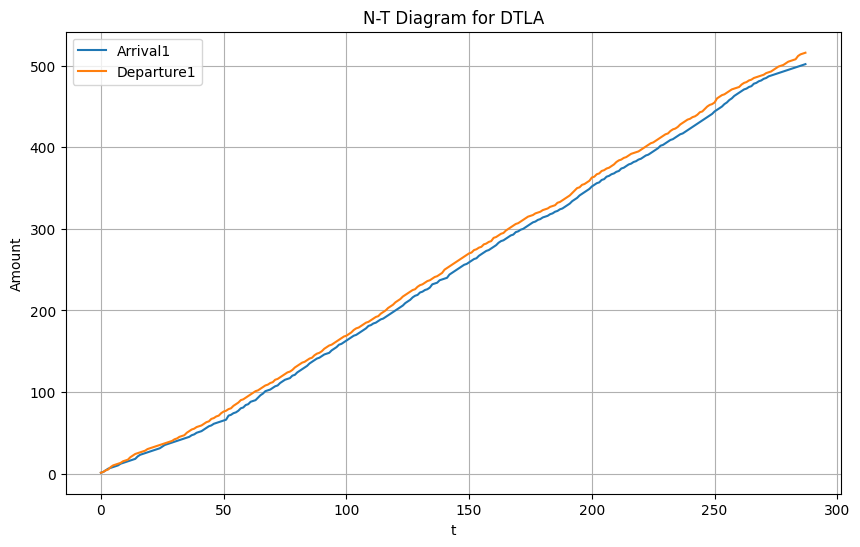

In [22]:
# Data from specificu
specificu_t01 = list(specificu01['t']+2)
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t'])
specificu_amount10 = list(specificu10['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(specificu_amount01[144:144+288]), label='Arrival1')
plt.plot(np.cumsum(specificu_amount10[144:144+288]), label='Departure1')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram for DTLA')
plt.legend()
plt.grid()
plt.show()


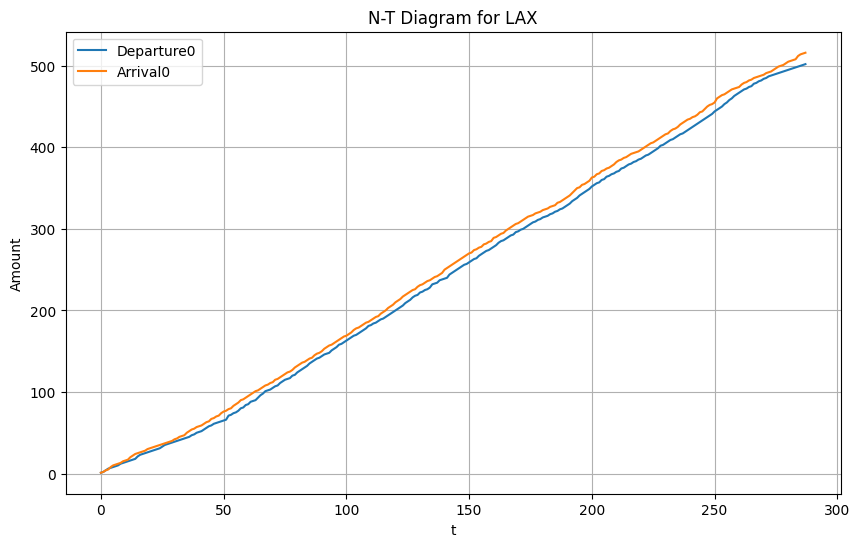

In [23]:
# Data from specificu
specificu_t01 = list(specificu01['t'])
specificu_amount01 = list(specificu01['amount'])
specificu_t10 = list(specificu10['t']+2)
specificu_amount10 = list(specificu10['amount'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(specificu_amount01[144:144+288]), label='Departure0')
plt.plot(np.cumsum(specificu_amount10[144:144+288]), label='Arrival0')
plt.xlabel('t')
plt.ylabel('Amount')
plt.title('N-T Diagram for LAX')
plt.legend()
plt.grid()
plt.show()
